In [58]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pylab
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tabulate import tabulate

In [2]:
from sklearn import datasets as ds

df = ds.fetch_openml(data_id=151,as_frame=True, return_X_y=True)

# Introdução

O data set a seguir nos trás dados sobre o preço da eletricidade nas cidades de New South Whale e 

In [3]:
df = (

    pd.concat(df, axis=1)

    .assign(target=lambda x: (x['class']=='UP')*1)

)

In [4]:
df.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class,target
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP,1
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP,1
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP,1
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP,1
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN,0


In [5]:
nswprice = df.nswprice
nswdemand = df.nswdemand
vicprice = df.vicprice
vicdemand = df.vicdemand

print('The shape of our features is:', df.shape)

The shape of our features is: (45312, 10)


In [6]:
# Descriptive statistics for each column
df.describe()

,date,period,nswprice,nswdemand,vicprice,vicdemand,transfer,target
count,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000
mean,0.499080,0.500000,0.057868,0.425418,0.003467,0.422915,0.500526,0.424545
std,0.340308,0.294756,0.039991,0.163323,0.010213,0.120965,0.153373,0.494279
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.031934,0.250000,0.035127,0.309134,0.002277,0.372346,0.414912,0.000000
50%,0.456329,0.500000,0.048652,0.443693,0.003467,0.422915,0.414912,0.000000
75%,0.880547,0.750000,0.074336,0.536001,0.003467,0.469252,0.605702,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df.dtypes

date          float64
day          category
period        float64
nswprice      float64
nswdemand     float64
vicprice      float64
vicdemand     float64
transfer      float64
class        category
target          int32
dtype: object

In [8]:
df["day"] = pd.to_numeric(df["day"])

In [9]:
>>> correlation_matrix = df.corr()
>>> correlation_matrix["target"]

date        -0.006303
day         -0.048279
period       0.155287
nswprice     0.379349
nswdemand    0.333933
vicprice     0.064624
vicdemand    0.234205
transfer    -0.122335
target       1.000000
Name: target, dtype: float64

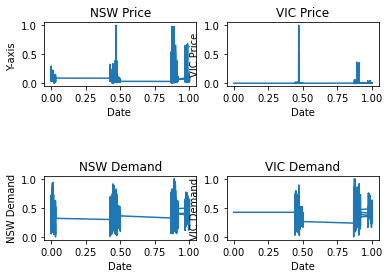

In [10]:
plt.subplot(3, 2, 1)
plt.plot(df.date, nswprice)
plt.title("NSW Price")
plt.xlabel('Date ')
plt.ylabel('Y-axis ')


plt.subplot(3, 2, 2)
plt.plot(df.date, vicprice)
plt.title("VIC Price")
plt.xlabel('Date')
plt.ylabel('VIC Price')

plt.subplot(3, 2, 5)
plt.plot(df.date, nswdemand)
plt.title("NSW Demand")
plt.xlabel('Date')
plt.ylabel('NSW Demand')

plt.subplot(3, 2, 6)
plt.plot(df.date, vicdemand)
plt.title("VIC Demand")
plt.xlabel('Date')
plt.ylabel('VIC Demand')

plt.show()

In [11]:
group_by_date = df.loc[:, ['date', 'nswprice', 'nswdemand']].groupby('date')
avgs = group_by_date.mean()
x = avgs.index
y1 = avgs.nswprice
def plot(x, y, ax, title, y_label):
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.plot(x, y)
    ax.margins(x=0, y=0)

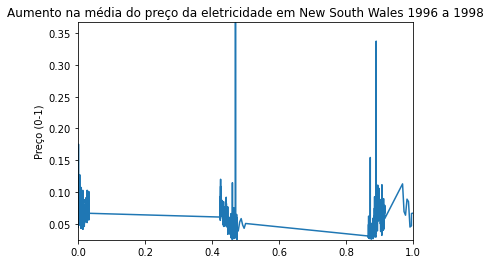

In [12]:
fig, ax = plt.subplots()
plot(x, y1, ax, 'Aumento na média do preço da eletricidade em New South Wales 1996 a 1998', 'Preço (0-1)')

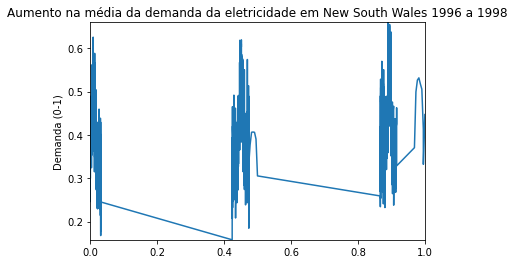

In [13]:
y2 = avgs.nswdemand
fig, ax = plt.subplots()
plot(x, y2, ax, 'Aumento na média da demanda da eletricidade em New South Wales 1996 a 1998', 'Demanda (0-1)')

In [14]:
## Testando Normalidade nas variáveis

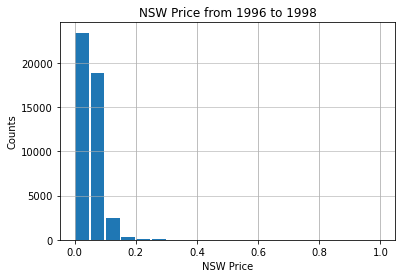

In [15]:
df.nswprice.plot.hist(grid=True,bins=20,rwidth=0.9)
plt.title('NSW Price from 1996 to 1998')
plt.ylabel('Counts')
plt.xlabel('NSW Price')
plt.grid(axis='y', alpha=0.75)

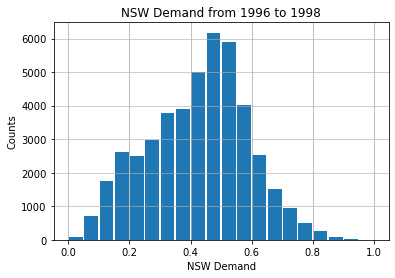

In [16]:
df.nswdemand.plot.hist(grid=True,bins=20,rwidth=0.9)
plt.title('NSW Demand from 1996 to 1998')
plt.ylabel('Counts')
plt.xlabel('NSW Demand')
plt.grid(axis='y', alpha=0.75)

Text(0.5, 0, 'NSW Demand')

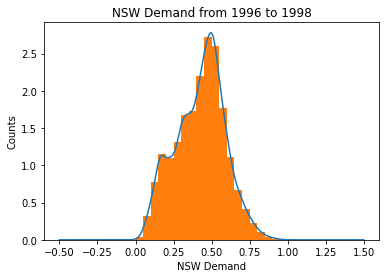

In [17]:
fig, ax = plt.subplots()
df.nswdemand.plot.kde(ax=ax, legend=False, title='NSW Demand from 1996 to 1998')
df.nswdemand.plot.hist(density=True, ax=ax,bins=20)
plt.ylabel('Counts')
plt.xlabel('NSW Demand')

<AxesSubplot:xlabel='nswprice', ylabel='Count'>

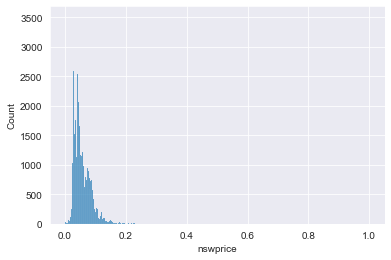

In [18]:
sns.set_style('darkgrid')
sns.histplot(df.nswprice)

<AxesSubplot:xlabel='vicprice', ylabel='Count'>

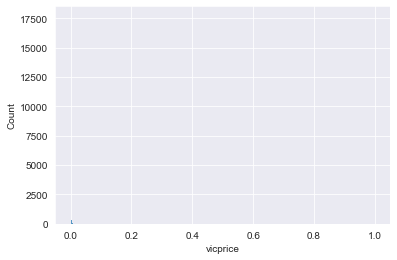

In [19]:
sns.set_style('darkgrid')
sns.histplot(df.vicprice)

<AxesSubplot:xlabel='nswdemand', ylabel='Count'>

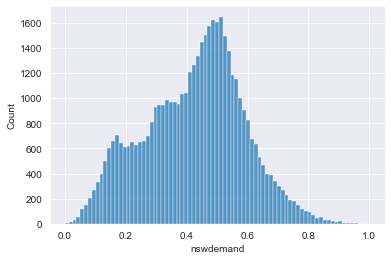

In [20]:
sns.histplot(df.nswdemand)

<AxesSubplot:xlabel='vicdemand', ylabel='Count'>

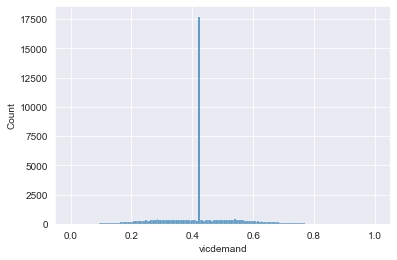

In [21]:
sns.histplot(df.vicdemand)

((array([-4.16899786, -3.9622    , -3.84941481, ...,  3.84941481,
          3.9622    ,  4.16899786]),
  array([0.      , 0.      , 0.      , ..., 0.981806, 0.981806, 1.      ])),
 (0.030221145123102266, 0.05786831013859463, 0.7556428703662484))

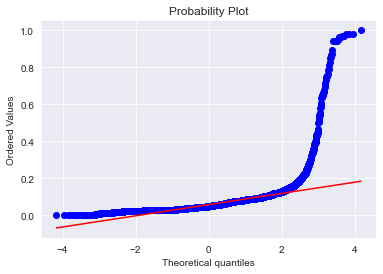

In [22]:
stats.probplot(df.nswprice, dist="norm", plot=pylab)

((array([-4.16899786, -3.9622    , -3.84941481, ...,  3.84941481,
          3.9622    ,  4.16899786]),
  array([0.      , 0.00119 , 0.001488, ..., 0.962511, 0.980809, 1.      ])),
 (0.16255185534600416, 0.4254178952595338, 0.9952009223530537))

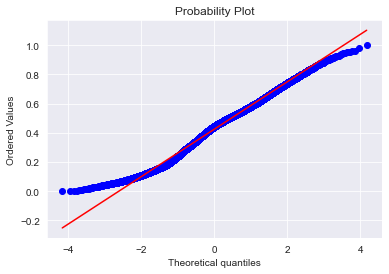

In [23]:
stats.probplot(df.nswdemand, dist="norm", plot=pylab)

((array([-4.16899786, -3.9622    , -3.84941481, ...,  3.84941481,
          3.9622    ,  4.16899786]),
  array([0.      , 0.      , 0.      , ..., 0.980682, 0.996228, 1.      ])),
 (0.002040413599105342, 0.0034670338983050835, 0.1997692688809712))

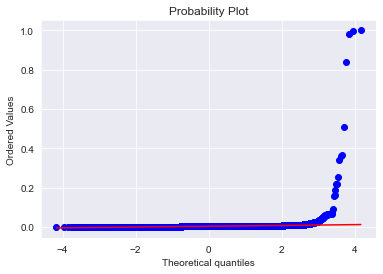

In [24]:
stats.probplot(df.vicprice, dist="norm", plot=pylab)

((array([-4.16899786, -3.9622    , -3.84941481, ...,  3.84941481,
          3.9622    ,  4.16899786]),
  array([0.      , 0.024081, 0.025634, ..., 0.991196, 0.996893, 1.      ])),
 (0.1174331447804295, 0.42291507571945613, 0.9707226174261446))

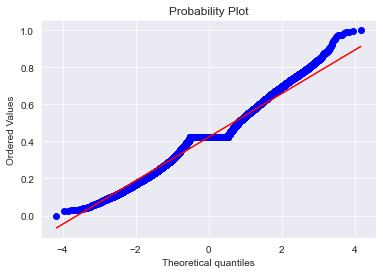

In [25]:
stats.probplot(df.vicdemand, dist="norm", plot=pylab)

In [52]:
X = df[['date','day','period','nswdemand','vicdemand','transfer']]
X = X.values
y = df[['target']]
print(y.value_counts())
y = y.values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

target
0         26075
1         19237
dtype: int64


In [53]:
26075/(26075+19237)

0.5754546257062146

In [45]:
log_regression = LogisticRegression()
log_regression.fit(X_train,y_train.ravel())

LogisticRegression()

In [48]:
y_pred = log_regression.predict(X_test)
# F1_score
results =f1_score(y_test,y_pred)

# Accuracy
print('Accuracy:', np.mean(results1))

Accuracy: 0.5526953926506248


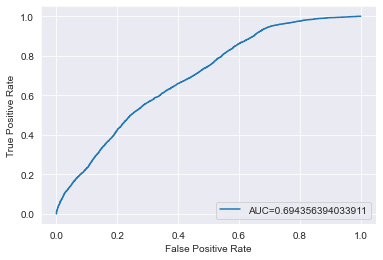

In [36]:
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [40]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train,y_train.ravel())

KNeighborsClassifier()

In [41]:
y_pred = model.predict(X_test)
results = f1_score(y_test,y_pred)

print('Accuracy:', np.mean(results))

Accuracy: 0.6977978243565933


In [31]:
from sklearn.model_selection import GridSearchCV
parameters = {"n_neighbors": range(1, 10)} # rodei 1 a 50 .. resultado 5 .. diminui para nao demorar muito quando rodasse novamente
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train.ravel())
gridsearch.best_params_

{'n_neighbors': 5}

In [32]:
y_pred_grid = gridsearch.predict(X_test)
results = []

results.append(f1_score(y_test,y_pred_grid))
print('Accuracy:', np.mean(results))

Accuracy: 0.6977978243565933


In [42]:
parameters = {
    "n_neighbors": range(1, 15),
    "weights": ["uniform", "distance"],
}

gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train.ravel())

gridsearch.best_params_

{'n_neighbors': 12, 'weights': 'distance'}

In [43]:
y_pred_grid = gridsearch.predict(X_test)
results = []

results.append(f1_score(y_test,y_pred_grid))
print('Accuracy:', np.mean(results))

Accuracy: 0.6959674566678459


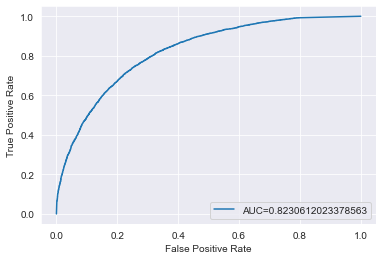

In [44]:
y_pred_proba = gridsearch.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

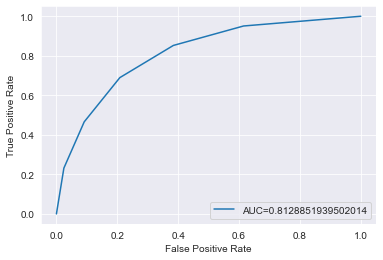

In [35]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train,y_train.ravel())

y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

AUC = 0.5 >> modelo não é melhor do que chutar ... AUC = 1 modelo acerta tudo ... O modelo acima não foi muito bom. 

In [78]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 500, random_state = 0)

# Train the model on training data
rf.fit(X_train, y_train.ravel())

RandomForestClassifier(n_estimators=500, random_state=0)

In [79]:
# Use the forest's predict method on the test data
y_pred = rf.predict(X_test)

accuracy_score(y_test, y_pred)

0.8273503016036486

Dado que as classes estao balanceadas a acuracia parece boa.

In [80]:
confusion_matrix(y_test,y_pred)

array([[6860, 1013],
       [1334, 4387]], dtype=int64)

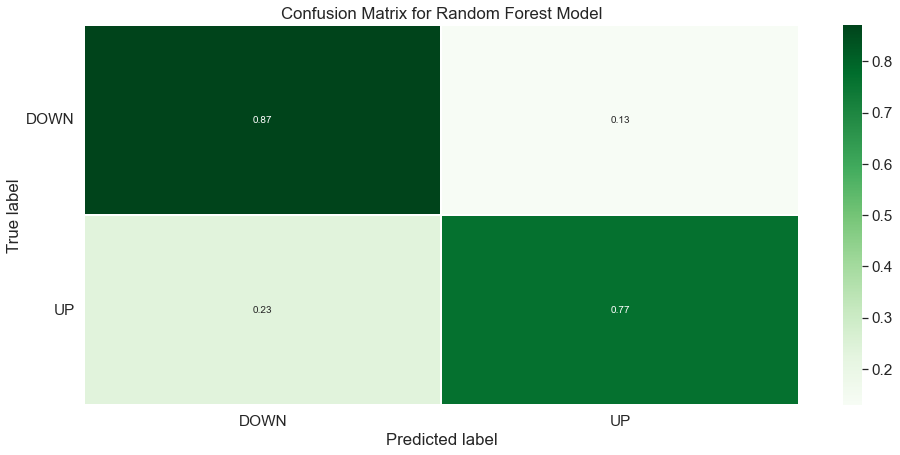

In [81]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)
# Add labels to the plot
class_names = ['DOWN', 'UP']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      7873
           1       0.81      0.77      0.79      5721

    accuracy                           0.83     13594
   macro avg       0.82      0.82      0.82     13594
weighted avg       0.83      0.83      0.83     13594



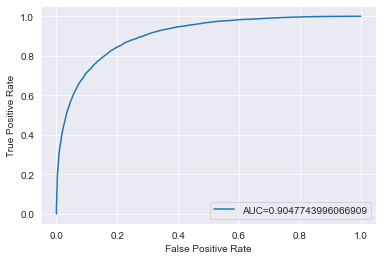

In [39]:
y_pred_proba = rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [83]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  P

In [119]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 500 decision trees
rf = RandomForestClassifier(n_estimators = 900, random_state = 0, criterion='entropy', max_features = 5) 

# Train the model on training data
rf.fit(X_train, y_train.ravel())

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=900,
                       random_state=0)

In [120]:
# Use the forest's predict method on the test data
y_pred = rf.predict(X_test)

accuracy_score(y_test, y_pred)

0.835221421215242

In [130]:
m

numpy.ndarray

# ver tabela

In [132]:
m = rf.feature_importances_
headers = ['date','day','period','nswdemand','vicdemand','transfer']

from prettytable import PrettyTable

x = PrettyTable(headers)
x.add_row(m)

Dado que as classes estao balanceadas a acuracia parece boa.

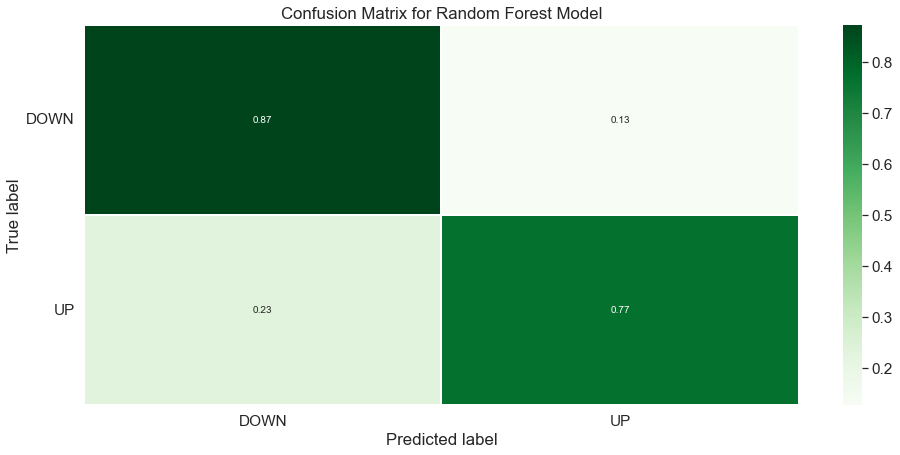

In [87]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)
# Add labels to the plot
class_names = ['DOWN', 'UP']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [88]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      7873
           1       0.81      0.77      0.79      5721

    accuracy                           0.83     13594
   macro avg       0.83      0.82      0.82     13594
weighted avg       0.83      0.83      0.83     13594



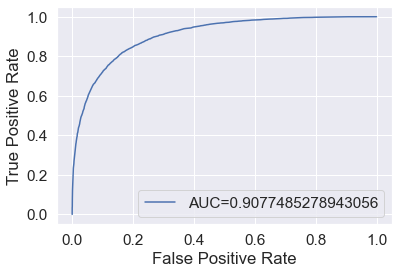

In [89]:
y_pred_proba = rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()